In [1]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# ==========================================
# parameters

# ------------------------------------------
# mesh
xmin = 0.0
xmax = 1.0
nel = 50000
p_order = 2

# ------------------------------------------
# material system (nondimensional)
d_NonDim = 1.20   # d/H
wl_NonDim = 0.10  # lambda/H
fe_NonDim = 1.0  # lambda*tao/k

d_NonDim = 0.3   # d/H
wl_NonDim = 0.10  # lambda/H
fe_NonDim = 0.001  # lambda*tao/k

In [3]:
class LoadStepper:

    """
    Time "integrator" for a problem with no time derivatives.  This 
    is basically just to keep track of a parameter, ``self.t``, that
    can be used to parameterize external loading.
    """

    def __init__(self,DELTA_T,t=0.0):
        """
        Initializes the ``LoadStepper`` with a (pseudo)time step ``DELTA_T``
        and initial time ``t``, which defaults to zero.
        """
        self.DELTA_T = DELTA_T
        self.tval = t
        self.t = Expression("t",t=self.tval,degree=0)
        self.advance()

    def advance(self):
        """
        Increments the loading.
        """
        self.tval += float(self.DELTA_T)
        self.t.t = self.tval

In [4]:
# ------------------------------------------
# time stepping
N_STEPS = 10
# N_STEPS = 1
DELTA_T = 1.0/float(N_STEPS)
stepper = LoadStepper(DELTA_T)

In [5]:
# ==========================================
# function bank
def strain(v):
    return grad(v)[0]

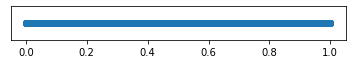

In [6]:
# ==========================================
# mesh
mesh = IntervalMesh(nel, xmin, xmax)

plot(mesh)

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], xmin, 1.e-14) and on_boundary
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], xmax, 1.e-14) and on_boundary

In [7]:
# This imposes a Dirichlet condition at the point x=0
def Dirichlet_x0_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-xmin)<tol

# This imposes a Dirichlet condition at the point x=1
def Dirichlet_x1_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-xmax)<tol

In [8]:
# =========================================
# function space
V1D = FiniteElement('CG',mesh.ufl_cell(),p_order)
# u1 and u2 for the bot and top layers
V   = FunctionSpace(mesh,MixedElement(V1D,V1D))

In [9]:
# =========================================
# BCs for the u1-u10 for each step
# --------------------------------------
# Enforce u1=0,u2=0 at x=0
#         u1=d/nstep      at x=1
# ---------------------------------------
bcs = [DirichletBC(V.sub(0), Constant(0),        Dirichlet_x0_boundary),
       DirichletBC(V.sub(1), Constant(0),        Dirichlet_x0_boundary),
       DirichletBC(V.sub(0), Constant(d_NonDim/N_STEPS), Dirichlet_x1_boundary)]

In [10]:
# =========================================
# define initial functions
uvec_0 = Function(V)

u1_0, u2_0 = split(uvec_0)
# initialize uvec_0
#

In [11]:
# =========================================
# define functions

# Define variational problem
ddu1, ddu2 = TestFunction(V)

duvec = Function(V)
du1, du2 = split(duvec)

u1 = u1_0 + du1
u2 = u2_0 + du2
# weak form
F = inner(strain(u1),strain(ddu1))*dx + \
    (1/d_NonDim)*(fe_NonDim)*(1/wl_NonDim)*sin(2*pi/wl_NonDim*d_NonDim*(u1-u2))*ddu1*dx + \
    inner(strain(u2),strain(ddu2))*dx - \
    (1/d_NonDim)*(fe_NonDim)*(1/wl_NonDim)*sin(2*pi/wl_NonDim*d_NonDim*(u1-u2))*ddu2*dx

J = derivative(F, duvec)
problem = NonlinearVariationalProblem(F, duvec, bcs, J)
solver  = NonlinearVariationalSolver(problem)

In [12]:
prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-9
# prm['newton_solver']['relative_tolerance'] = 4E-8
# prm['newton_solver']['relative_tolerance'] = 1E-6
# prm['newton_solver']['maximum_iterations'] = 50
prm['newton_solver']['relaxation_parameter'] = 0.5

------- Step: 0 , t = 0.1 -------
------- Step: 1 , t = 0.2 -------
------- Step: 2 , t = 0.30000000000000004 -------
------- Step: 3 , t = 0.4 -------
------- Step: 4 , t = 0.5 -------
------- Step: 5 , t = 0.6 -------
------- Step: 6 , t = 0.7 -------
------- Step: 7 , t = 0.7999999999999999 -------
------- Step: 8 , t = 0.8999999999999999 -------
------- Step: 9 , t = 0.9999999999999999 -------


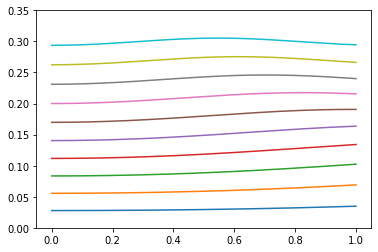

In [13]:
for i in range(N_STEPS):
    print("------- Step: "+str(i)+" , t = "+str(stepper.tval)+" -------")
    solver.solve()
    uvec_0.vector()[:] = uvec_0.vector()+duvec.vector()
    # ---------------------------
    # for plot
    plot(strain(u1_0))
    plt.xlim(0.0-0.05,1.0+0.05)
    plt.ylim(0.0,d_NonDim+0.05)
    # ---------------------------
    stepper.advance()

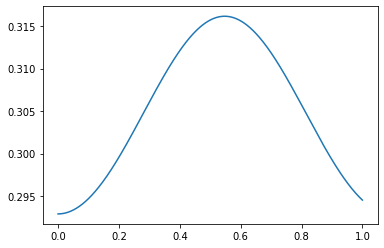

In [14]:
# final
# check
# ------------------------------
plt.figure()
plot(strain(u1_0-u2_0))

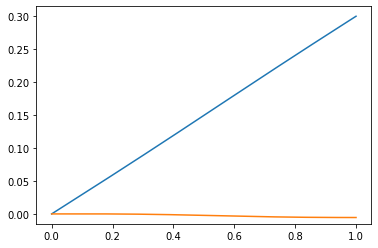

In [17]:
plt.figure()
plot(u1_0)
plot(u2_0)